# PS RBC tuning simulation
This script is used to numerically evaluate the SBO and CSBO tuning performance on the parameters of the ES RBC. To run this script, first you will need to run **simulation/NLopt_mp.py** and **simulation/grid_mp.py**. The results of the last script are used to calculate the kernel hyperparameters.

## Import dependencies

In [4]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'..')
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow import keras
mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.grid'] = True
#Define constants
hour=60
day=24*hour
#Battery capacity
C=96 #kWh
#Deviation of the battery capacity (for simulations with modified capacity, e.g. 500kWh capacity --> Cdev=5)
Cdev=1
#Hard constraints on the SoC, 30-80%
soc_lim=np.array([30,80])
#Maximum charge/discharge power
p_bat_lim=1*C #1C 
#Normalizing constants
p_std=p_bat_lim
soc_std=soc_lim[1]-soc_lim[0]# do not change unless necesary
#Set SoC reference
soc_ref=(soc_lim[1]+soc_lim[0])/2
#Define soft constraints (for constraint metric)
soc_softc=[32,80]
S_f_sp=55
#Set samplin time
dt=1
# Import ANN battery model
# bat_dense_model=tf.keras.models.load_model('../ES_model/saved_models/p-dsoc_2-7-1_.h5')
phib=np.asarray(pd.read_csv('../battery/PWLmodel_par_opti.csv',index_col='Unnamed: 0'))
#Get load power data
data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)

## Set simulation framework

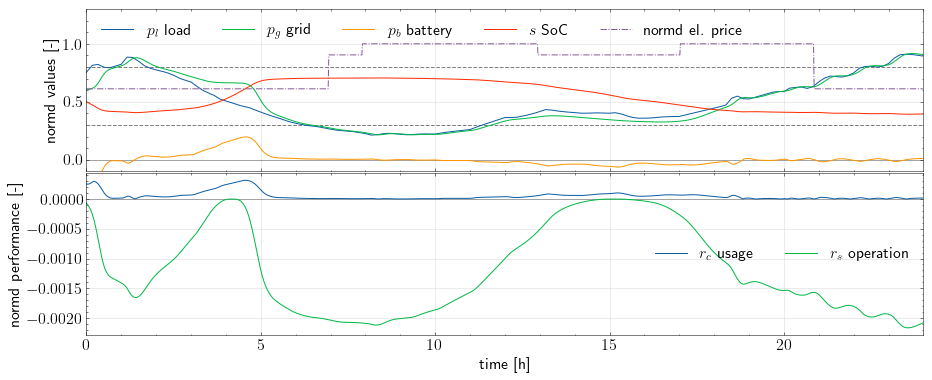

((-0.017120817639387338,
  2.028486153362231,
  0.038469810247711164,
  0.07336561871235284),
 39.47617231725089,
 39.26158916582326)

In [10]:
#Define battery model generator
def batt_model_generator(x,soc_i,mtype='PWL',model=None):
    # Creates generator of the battery model
    # x: battery model parameters
    # soc_i: initial SoC
    # mtype: set to 'PWL' for EPWL and 'ANN' for ANN model
    # model: tensorflow model
    # first siganl out is IC when initialized (send(None))
    # send(power) for next signal
    if mtype=='PWL':
        cut1=x[5]
        cut2=x[6]
        def soc_func(soc,p):
            dsoc=x[0]+x[1]*max(cut1,p)+x[2]*max(0,p)+x[3]*max(cut2,p)+x[4]*p
            if dsoc>x[9]: dsoc=x[7]*dsoc
            if dsoc<x[10]: dsoc=x[8]*dsoc
            return soc+dsoc/Cdev
    if mtype=='ANN':
        assert model is not None                            
        def soc_func(soc,p):
            dsoc=model.predict(np.atleast_2d([p])).flatten()
            return soc+dsoc
    soc=soc_i
    p=0
    while True:
        p=yield soc
        soc=soc_func(soc,p)[0]
          
# Define electricity price (aprox. from Endesa, Spain)      
#El. prices of time slots
P1=188 # buy price in euro/MWh
P2=170
P3=115
S1=53 #sell price in euro/MWh
B1=1
def price_fun(k=None):
    price=DemandSignal(day,dt,1)
    price.step_signal([0.29,0.33,0.54,0.71,0.87],[P3,P2,P1,P2,P1,P3])
    if k is None:
        return price.signal
    else:
        return price.signal[k]

def batt_control_generator(dt,a,soc_lim,p_bat_lim,N,past,p_set=[0,4],T=day,soc_ref=soc_ref):
# Creates a generator of the BMS
# P_bat >0 for charging 
# a: array, RBC parameters
# soc_lim: array, SoC limits (0,100)
# p_bat_lim: battery charge and discharge limits in kW
# N: array, moving avarage window widths
# dt: sampling period in minutes
#past: past 24h mmnts on the power_demand
        #Time step
        k=0
        soc_ref=soc_ref
        soc=50
        # Demand average
        p_avg=past[-N[0]//dt:].sum()/past[-N[0]//dt:].size
        # Current RBC of the supercap at NEST (we assume infinte capacitance, it acts as a band stop filter on the load power)
        def p_cap():
            p_2=past[-15//dt:].sum()/past[-15//dt:].size
            p_1=past[-1//dt:].sum()/past[-1//dt:].size
            return p_2-p_1
        # SoC reference tracking
        def p_soc_lim(g):
            #This term aims to reduce deviations from the reference SoC. 
            #g: exponetial term, used to characterize the stiffness against deviations
            dsoc=soc_ref-soc
            if dsoc>0:
                return (abs(dsoc)/soc_std*2)**g
            else:
                return -(abs(dsoc)/soc_std*2)**g
        #24h-average load power tracking
        def p_24h_average_tracking():
            p_avg_day=past[-N[1]//dt:].sum()/past[-N[1]//dt:].size
            return p_avg_day-p_avg            

        def control_3_3_0():
            #Peak-shaving with flat bound
            #Same charge and discharge bound
            #Par: expansion, gamma, (allow take power from the grid )
            p_bound=p_bat_lim
            max_dis=a[0]*p_bound
            p_bat=np.clip(p_24h_average_tracking(),-max_dis,max_dis)
            p_bat=p_bat+max_dis*p_soc_lim(a[1])
            if p_avg>0 :
                return np.clip(p_bat,-p_avg,None)
            else:
                return np.clip(p_bat,0,-p_avg) 

                
        while True:
            p_avg=past[-N[0]//dt:].sum()/past[-N[0]//dt:].size
            #Last 30 mins of the experiment are used to reset the SoC to 55%. The reset time can be changed by modifying Nfinal
            Nfinal=24
            if k*dt/day<Nfinal/24:
                p_bat=control_3_3_0()
            else:
                p_bat=p_bat_lim*p_soc_lim(1)
            # Max charge/discharge power saturation 1C
            p_bat=np.clip(p_bat,-p_bat_lim,p_bat_lim)
                
            soc,soc_ref,p_dem,k=yield p_bat,p_cap()# gets soc, soc_ref, p_dem, k; returns p_bat and p_cap
            #Append last demand power
            past=np.append(past,p_dem)

def add_sin_noise(x,period,amp,rnd=0.5,k=None):
#This function adds sinusoidal noise to a signal x
#period: noise period
#amp: noise amplitud
#rnd: randomization level
#k: timestep
    if k is None:
        t=np.arange(len(x))*dt
        phase_noise=2*rnd*np.pi*np.random.rand(len(x))
        w=2*np.pi/period
        n=amp*np.sin(w*t+phase_noise)
        return x+n
    else:
        t=k*dt
        phase_noise=2*rnd*np.pi*np.random.rand()
        w=2*np.pi/period
        n=amp*np.sin(w*t+phase_noise)
        return x+n  

def plant_cost(x,T=1,p_load=data.power_load.values,N_lim=[15,day],soc_lim=soc_lim,soc_softc=soc_softc,soc_i=50,phib=phib,plot=False,plot_path=None,
               soc_ref=soc_ref,dt=1,p_set=[0,4],noise=False,Nfinal=24):
# Takes new control parameters, simulates a day and outputs performance and contrain metrics  
# x: array, RBC parameters
# T: optimization period in days
# soc_lim: array, SoC limits 
# soc_ref: reference for SoC controler
# dt: sampling period in minutes
# N_lim: array, moving avarage window widths for peak shaving 
# p_set: power upper limit for band gap controller
# noise: if True adds noise to all signals in the simulation
# plot: if True plots simulation values
# plot_cost: if True plots the metrics values

    mpl.rcParams['figure.figsize'] = (20, 5)
    dt=dt
    T=T*day//dt
    p_load=p_load[:T+N_lim[1]]
    bc=batt_control_generator(dt,x,soc_lim,p_bat_lim,N_lim,p_load[:N_lim[1]//dt],p_set=p_set,T=T)
    p_load=p_load[N_lim[1]//dt:]
    bm=batt_model_generator(phib,soc_i)
    soc=[bm.send(None)] #Initialize battery model ->SoC_0
    bc.send(None)
    p_bat=[] #Initiliazation controller
    p_grid=[]
    p_2=[]
    p_1=[]
    #Run noisy simulation
    if noise:
        for k,po in enumerate(p_load):
            p_bat+=[bc.send((add_sin_noise(soc[-1],hour,0.5,0.5,k),soc_ref,add_sin_noise(po,hour,load_noise,0.5,k),k))[0]]
            p_cap=bc.send((add_sin_noise(soc[-1],hour,0.5,0.5,k),soc_ref,add_sin_noise(po,hour,load_noise,0.5,k),k))[1]
            soc+=[bm.send(add_sin_noise(p_bat[-1],hour,bat_noise,1,k))]
            p_grid+=[p_bat[-1]+po+p_cap]
    #Run simulation without noise
    else:
        for k,po in enumerate(p_load):
            p_bat+=[bc.send((soc[-1],soc_ref,po,k))[0]]
            p_cap=bc.send((soc[-1],soc_ref,po,k))[1]
            soc+=[bm.send(p_bat[-1])]
            p_grid+=[p_bat[-1]+po+p_cap]                   
    # Save last soc for initial point next iteration
    soc_f=soc[int(T*Nfinal/24)]
    soc=np.array(soc[:-1])
    p_grid=np.array(p_grid)
    p_bat=np.array(p_bat)
    # Plot SoC, P_bat, P_grid and P_load   

    # Define performance metrics
    def cost_f(plot=plot):
        #Define SoC ref deviation metric
        soc_norm=np.abs(np.power((soc-soc_ref)/soc_std,3))
        soc_norm=soc_norm
        #Define monetary metric
        def r_price_sell_fun():    
            def price_sell_map_fun(p_bat,p_load,f_buy,f_sell,f_bat):
                if (-p_bat<=p_load)&(p_load>=0):
                    return -p_bat*f_buy + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat>p_load)&(p_load>=0):
                    return -f_sell*(p_bat+p_load)+f_buy*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat<=p_load)&(p_load<0):
                    return -f_buy*(p_bat+p_load)+f_sell*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat>p_load)&(p_load<0):
                    return -p_bat*f_sell + max(0,np.sign(-p_bat))*p_bat*f_bat
                else: return 0
            return np.array(list(map(price_sell_map_fun,p_bat,p_load,price_fun(),S1*np.ones(T),B1*np.ones(T))))/hour*dt*1e-3 # [euro]
        r_price_sell=r_price_sell_fun()
        # Discharge power metric
        g_b_dis=-np.maximum(np.zeros_like(p_bat),np.sign(-p_bat))*p_bat*B1/hour*dt*1e-3 # cost only when discharging in euro
        # Battery use metric
        g_b=np.abs(p_bat)*B1/hour*dt*1e-3 # battery cost ch/dis in euro
#       Plot different costs; for experiment evaluation
        if plot:
            with plt.style.context('science'):
                plt.rcParams.update({'font.size': 16})
                fig,ax=plt.subplots(2,sharex=True,figsize=(15,6))


                time=np.arange(0,p_load.size)/60
                ax[0].plot(time,p_load/p_std,label=r'$p_l$ load')
                ax[0].plot(time,p_grid/p_std,label=r'$p_g$ grid')
                ax[0].plot(time,p_bat/p_std,label=r'$p_b$ battery')
                ax[0].plot(time,soc/100,label='$s$ SoC')
                ax[0].plot(time,price_fun()/P1,'-.',label='normd el. price')
                ax[0].hlines(0,0,time[-1],'k',alpha=0.3)
                ax[0].hlines(soc_lim[0]/100,0,time[-1],linestyles='--',color='grey')
                ax[0].hlines(soc_lim[1]/100,0,time[-1],linestyles='--',color='grey')
                ax[0].locator_params(nbins=4)
                ax[0].set_ylim([-0.1,1.3])            

                ax[0].set_ylabel('normd values [-]')
                ax[0].set_xlim([0,24])
                ax[0].legend(ncol=5)
                ax[0].grid(alpha=0.5)

    #                 plt.plot(time,p_bat_soc,label='battery reward')
    #                 plt.plot(time,r_ps,label='peak-shaving reward')
    #             plt.plot(time,r_price,label='monetary reward')
                ax[1].hlines(0,0,time[-1],'k',alpha=0.3)
                ax[1].plot(time,g_b,label='$r_c$ usage')
    #             plt.plot(time,p_grid_norm,label='grid_cost')
                ax[1].plot(time,-soc_norm/T*100,label='$r_s$ operation')
                ax[1].locator_params(nbins=6)     
                ax[1].set_xlabel('time [h]')    
                ax[1].set_ylabel('normd performance [-]')        
    #             ax[1].set_ylim([-0.1,1.2])                 
    #             plt.plot(time,soc_lim_cost,label='soc_lim_cost')
    #             plt.plot(time,ps_norm,label='ps_grid_cost')
    #             plt.plot(time,p_bat_ps_norm,label='ps_batt_cost')
    #             plt.plot(time,mask,label='mask')
                ax[1].legend(ncol=2)
                ax[1].grid(alpha=0.5)
                plt.subplots_adjust(hspace=0.01)
                if plot_path is not None:
                    plt.savefig(plot_path)        
            plt.show()
            
        return  -soc_norm.sum()/T,r_price_sell.sum(),g_b_dis.sum(),g_b.sum()


    #Find local SoC minimum without taking into consideration the intial SoC
    def local_soc_min(s,si):
        if min(s)<si:
            return min(s)
        else:
            order=hour/dt
            base_idx=signal.argrelmin(s,order=int(order))[0]
            if len(s[base_idx])>0:
                return min(s[base_idx])
            else :
                return s[-1]


    return cost_f(),soc_f,local_soc_min(soc,soc_i)

plant_cost([4 ,5],plot=True)

## Find kernel hyperparameters
Get kernel hyperparamters which minimize the log marginal likelihood over the grid evaluation. If a grid evaluation was not performed yet, please run the /simulation/grid_mp.py script or use the already obtained hyperparameters in /simulation/hps/PSRBC/*.

### RBF

initial SoC: 50
initial SoC: 50
initial SoC: 50
initial SoC: 50
[[0.03899311 0.26756763]] [[1. 1.]]
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
initial SoC: 50
initial SoC: 50
initial SoC: 50
initial SoC: 50
context=  [[0.45582831]]
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
opt parameter and cost:  [0.8241206  1.50251256] [0.05994107 0.15926063]
current max estiamte ucb=  (array([0.59296482, 1.75376884]), 0.07009422248584661, 0.07260455510975818)
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
context=  [[0.57490597]]
initial SoC: 42.85266744279764
initial SoC: 41.97474263195795
initial SoC: 40.01613060349406
initial SoC: 37.19768298765618
opt parameter and cost:  [0.66331658 1.3517587

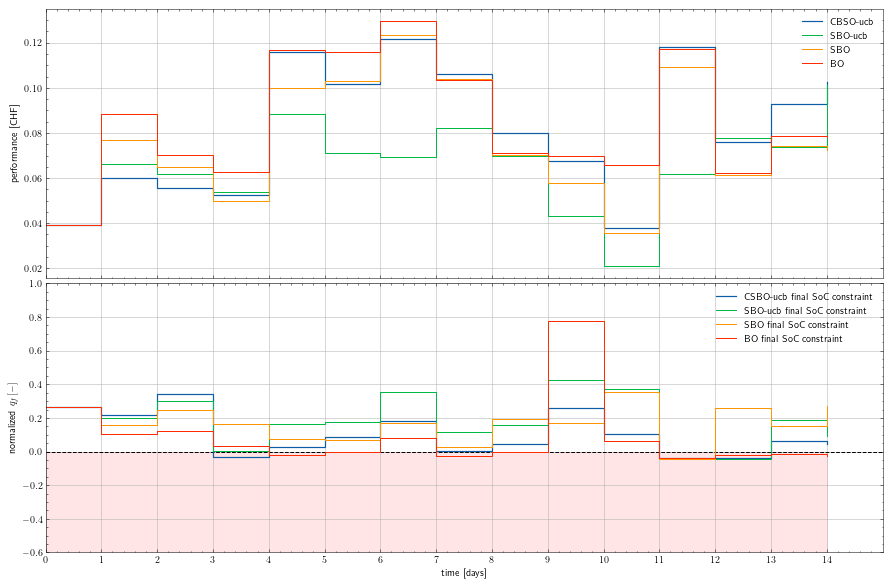

sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b0.5_CSBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b0.5_CSBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b0.5_CSBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b0.5_CSBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b0.5_SBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b0.5_SBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b0.5_SBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b0.5_SBO_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b0.5_SBOb_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b0.5_SBOb_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b0.5_SBOb_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b0.5_SBOb_2022_06_03_0333
sim_data_330_winter_1gb_0.5gsoc_qs_32/

initial SoC: 34.579520903846834
initial SoC: 32.91737251173897
initial SoC: 35.864418857419366
initial SoC: 30.624663634144188
opt parameter and cost:  [1.25628141 4.06532663] [0.08728881 0.0510793 ]
current max estiamte ucb=  (array([1.2361809, 4.2160804]), 0.08810253351440568, 0.08845954931943244)


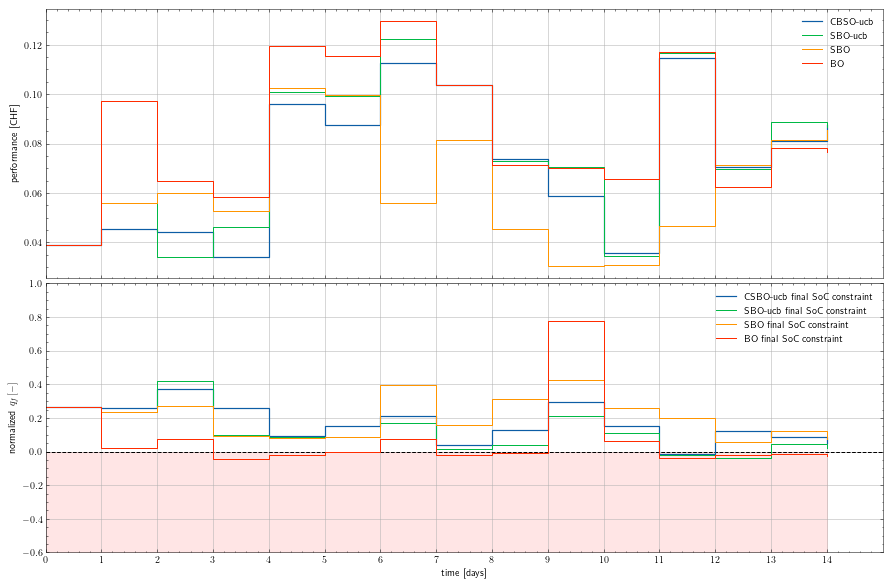

sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b1_CSBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b1_CSBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b1_CSBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b1_CSBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b1_SBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b1_SBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b1_SBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b1_SBO_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b1_SBOb_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b1_SBOb_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b1_SBOb_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b1_SBOb_2022_06_03_0334
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b1_BO_20

initial SoC: 32.25163344002224
initial SoC: 39.98047321263522
initial SoC: 29.847440299724145
opt parameter and cost:  [0.92462312 3.11055276] [0.09226377 0.03745226]
current max estiamte ucb=  (array([0.7839196 , 1.40201005]), 0.11244463631546908, 0.11403988915782881)


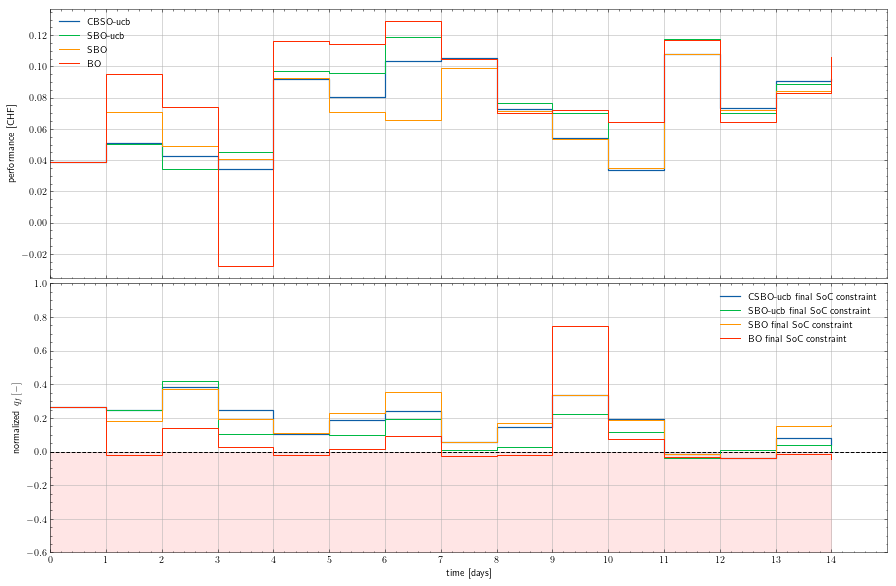

sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b2_CSBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b2_CSBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b2_CSBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b2_CSBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b2_SBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b2_SBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b2_SBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b2_SBO_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b2_SBOb_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_post_loglike2_b2_SBOb_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_prior_loglike2_b2_SBOb_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/y_prior_loglike2_b2_SBOb_2022_06_03_0335
sim_data_330_winter_1gb_0.5gsoc_qs_32/x_post_loglike2_b2_BO_20

In [37]:
# Select hyperparamters
hp1=get_data('hps/PSRBC/hyperpar_loglike1_b2.npy')
hp2=get_data('hps/PSRBC/hyperpar_loglike2_b2.npy')
hp3=get_data('hps/PSRBC/hyperpar_loglike3_b2.npy')
hp4=get_data('hps/PSRBC/hyperpar_loglike4_b2.npy')
hps=[hp2]
for idx,hp in zip([2],hps):
    for beta in [0.5,1,2]:
        Vz=hp[0]
        Lz=hp[1]
        Vq=hp[2]
        Lq=hp[3]
        Vqs=hp[4]
        Lqs=hp[5]
        beta=beta
        Lctxt_z=hp[7]
        Lctxt_q=hp[8]
        Lctxt_qs=hp[9]

        noise_cst = 1e-5#cst_mmnt_noise.mean()/10
        noise_const =2e-5
        noise_safeconst =2e-5
        S_f_sp=55
        S_os_max=0
        soc_lim=[30,80]
        soc_softc=[32,80]
        soc_i=50
        w=[1,0.5]
        # opt_cost=rnd_opt_cst[0]
        def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=soc_i,phib=phib):
            p_load=data[:T*day+N_lim[1]]
            x=x0
            i=0
            static=False
            while True:
#                 i=0 #always first day
#                 soc_i=50 #always same soc_i
                res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,noise=False)
                c=res[0]
                q=res[1:] 
                if static==False: soc_i_=q[1]
                print('initial SoC:', soc_i)
                x,i,static=yield w[0]*c[3]+w[1]*c[0],(q[1]-soc_softc[0])/soc_std,q[0]/100
                p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
                if static==False: soc_i=soc_i_
        bounds = [(0., 2.),(1,11)]
        parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
        # parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
        # Define Kernel
        # for x_ in np.random.uniform(-0.5,-0.05,10):

        cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
        cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
        cost_kernel=cost_kernel_*cost_context_kernel

    #     const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
    #     const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
    #     const_kernel=const_kernel_*const_context_kernel

        safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
        safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
        safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

        x0=np.array([[1.,1]])
        cost=cost_g(x0.flatten())
        cost_=cost_g(x0.flatten())                
        cost__=cost_g(x0.flatten())
        costva=cost_g(x0.flatten())

        cost_.send(None)
        cost__.send(None)
        costva.send(None)
        res=cost.send(None)


        y0= np.atleast_2d(res[:-1])
        context=np.atleast_2d([soc_i/100])
        x=np.hstack([x0,context])
        print(y0,x0)
        cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
    #     const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
        safeconst_gp= GPy.models.GPRegression(x,y0[:,1,None], safeconst_kernel, noise_var=noise_safeconst)

        cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
    #     const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
        safeconst_gp_= GPy.models.GPRegression(x0,y0[:,1,None], safeconst_kernel_, noise_var=noise_safeconst)

        gp=[cost_gp,safeconst_gp]
        gp_=[cost_gp_,safeconst_gp_]
        gp__=[cost_gp_.copy(),safeconst_gp_.copy()]
        gpva=[cost_gp_.copy(),safeconst_gp_.copy()]

        # The optimization routine
        optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf], threshold=np.array([-np.inf,-50]),beta=beta)
        opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,0], threshold=np.array([-np.inf,-50]),beta=beta)
        opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,0], threshold=np.array([-np.inf,-50]),beta=beta)
        opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,0], threshold=np.array([-np.inf,-50]),beta=beta,num_contexts=1)
        # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
#         iterations=len(data)*dt//day-2
        iterations=15

        y_post=np.empty((iterations,y0.shape[1]))
        x_post=np.empty((iterations,x0.shape[1]))
        x_prior=np.empty((iterations,x0.shape[1]))
        y_prior=[]
        y_prior.append(y0.flatten())

        y_post_=np.empty((iterations,y0.shape[1]))
        x_post_=np.empty((iterations,x0.shape[1]))
        x_prior_=np.empty((iterations,x0.shape[1]))
        y_prior_=[]
        y_prior_.append(y0.flatten())

        y_post__=np.empty((iterations,y0.shape[1]))
        x_post__=np.empty((iterations,x0.shape[1]))
        x_prior__=np.empty((iterations,x0.shape[1]))
        y_prior__=[]
        y_prior__.append(y0.flatten())

        y_postva=np.empty((iterations,y0.shape[1]))
        x_postva=np.empty((iterations,x0.shape[1]))
        x_priorva=np.empty((iterations,x0.shape[1]))
        y_priorva=[]
        y_priorva.append(y0.flatten())

        for i in range(iterations):
            # Get optimizer for same day
            try:
                x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
                x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
                x_post__[i,:] = opt.optimize()
                x_postva[i,:] = optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0)[0]
                x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0)[0]
                x_post__[i,:]=opt.get_maximum(beta_estimate=0)[0]
                x_postva[i,:]=optva.get_maximum(beta_estimate=0)[0]

            y_post[i,:] = cost.send((x_post[i,:].flatten(),i,True))[:-1]
            y_post_[i,:] = cost_.send((x_post_[i,:].flatten(),i,True))[:-1]
            y_post__[i,:] = cost__.send((x_post__[i,:].flatten(),i,True))[:-1]
            y_postva[i,:] = costva.send((x_postva[i,:].flatten(),i,True))[:-1]

        #     if y_post[i,1]<-1e-1:
        #         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
        #         break
            # Get context of day
            context=np.atleast_2d([res[-1]])
            print('context= ',context)
            try:
                x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
                x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
                x_prior__[i,:] =  opt.optimize(ucb=False)
                x_priorva[i,:] =  optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
                x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
                x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
                x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]    

            res = cost.send((x_prior[i,:].flatten(),i+1,False))
            y_prior.append(res[:-1])
            y_prior_.append(cost_.send((x_prior_[i,:].flatten(),i+1,False))[:-1])
            y_prior__.append(cost__.send((x_prior__[i,:].flatten(),i+1,False))[:-1])    
            y_priorva.append(costva.send((x_priorva[i,:].flatten(),i+1,False))[:-1])    


            print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
            opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
            opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
            opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
            optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 
            print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))

        y_prior=np.array(y_prior[:-1])
        y_prior_=np.array(y_prior_[:-1])
        y_prior__=np.array(y_prior__[:-1])
        y_priorva=np.array(y_priorva[:-1])

    #     err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
    #     print(np.abs(err).sum()/(iterations-10))

        # mpl.rcParams['text.usetex']=True

        with plt.style.context('science'):
            err=25e-2
            # plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
            fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
    #         ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    #         ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    #         ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    #         ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    #         ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')

            ax[0].step(range(iterations),y_prior[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
            ax[0].step(range(iterations),y_prior_[:,0],where='post',label='SBO-ucb')
            ax[0].step(range(iterations),y_prior__[:,0],where='post',label='SBO')
            ax[0].step(range(iterations),y_priorva[:,0],where='post',label='BO')

            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel('performance [CHF]')
            ax[0].legend()

            # plt.step(range(iterations),-y_meas[:,1],where='post',label='SafeOpt')
    #         ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    #         ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    #         ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    #         ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
            ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)

            ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
            ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
            ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
            ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')

            # ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SO prior final SoC constraint')
            # ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSO prior final SoC constraint')
            ax[1].set_ylim([-0.6,1])
            ax[1].set_ylabel(r'normalized $q_f [-]$')
            ax[1].legend()

            # ax[2].step(range(iterations),y_post[:,2],where='post',label='bound SoC constraint')
            # ax[2].step(range(iterations),y_prior[:,2],where='post',label='bound final SoC constraint')
            # ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            # ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            # ax[2].set_ylim([-0.1,1])
            # ax[2].legend()
            plt.xlabel('time [days]')
            plt.xlim([0,iterations])
            plt.subplots_adjust(hspace=0.02)
    #         plt.savefig(f'RBC312_rp_b0_qf_55_beta_{beta}_{par_names[idx]}_model.png')
        plt.show()
    #     name=f'{par_names[idx]}_b{beta}_'
        name=f'loglike{idx}_b{beta}_'
        optype='CSBO'
        sim_dir=f'sim_data_330_winter_{w[0]}gb_{w[1]}gsoc_qs_32'
        save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBO'
        save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBOb'
        save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
        optype='BO'
        save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

        save_data(hp,'hyperpar_'+name,folder=sim_dir)
        save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)
        save_data(opt_ucb_.gps,'SBO_'+name,folder=sim_dir,pick=True,npy=False)    

### Mattern32

In [79]:
# Winter hyperparamters
hp1=[5.8**2,[1.9,1.12], #cost
    0.27**2,[0.95,0.478],# const
    0.25**2,[0.59, 0.38],#safe 
    2,#beta
    2.45,1.35,0.841] #contexts lenght
hp2=[4**2,[1.28,0.937], #cost
    0.303**2,[1.62,0.757],# const
    0.309**2,[0.695, 0.697],#safe 
    2,#beta
    1.08,1.49,0.543] #contexts lenght

hp3=[4.9**2,[1.3,0.698], #cost
    0.3**2,[0.682,0.478],# const
    0.263**2,[0.425, 0.472],#safe 
    2,#beta
    1.06,0.3,0.77] #contexts lenght

hps=[hp1,hp2,hp3]

In [35]:

from itertools import product
betas=[0.5,1,2]
for beta in betas:
    for idx,hp in enumerate(hps):
        print(beta,hp)
        e_ch=data.e_char.asfreq('D').shift(-2).dropna()
        ctxt=e_ch
        Vz=hp[0]
        Lz=hp[1]
        Vq=hp[2]
        Lq=hp[3]
        Vqs=hp[4]
        Lqs=hp[5]
        beta=beta
        Lctxt_z=hp[7]
        Lctxt_q=hp[8]
        Lctxt_qs=hp[9]

        noise_cst = 1e-2#cst_mmnt_noise.mean()/10
        noise_const =2e-5
        noise_safeconst =1e-6
        S_f_sp=55
        S_os_max=0
        soc_lim=[30,80]
        soc_softc=[32,80]
        def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=soc_i,phib=phib):
            p_load=data[:T*day+N_lim[1]]
            x=x0
            i=0
            static=False
            while True:
#                 i=0 #always first day
#                 soc_i=50 #always same soc_i
                res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,noise=False)
                c=res[0]
                q=res[1:] 
                if static==False: soc_i_=q[1]
                print('initial SoC:', soc_i)
                x,i,static=yield c[3]+2*c[0],(q[1]-soc_softc[0])/soc_std,q[0]/100
                p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
                if static==False: soc_i=soc_i_
        bounds = [(0., 2.),(1,11)]
        parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
        # parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
        # Define Kernel
        cost_kernel_ = GPy.kern.Matern32(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
        cost_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
        cost_kernel=cost_kernel_*cost_context_kernel

        const_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
        const_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
        const_kernel=const_kernel_*const_context_kernel

        safeconst_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
        safeconst_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
        safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

        x0=np.array([[1.,1]])
        cost=cost_g(x0.flatten())
        cost_=cost_g(x0.flatten())                
        cost__=cost_g(x0.flatten())
        costva=cost_g(x0.flatten())

        cost_.send(None)
        cost__.send(None)
        costva.send(None)
        res=cost.send(None)


        y0= np.atleast_2d(res[:-1])
        context=np.atleast_2d([soc_i/100])
        x=np.hstack([x0,context])
        print(y0,x0)
        cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
    #     const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
        safeconst_gp= GPy.models.GPRegression(x,y0[:,1,None], safeconst_kernel, noise_var=noise_safeconst)

        cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
    #     const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
        safeconst_gp_= GPy.models.GPRegression(x0,y0[:,1,None], safeconst_kernel_, noise_var=noise_safeconst)

        gp=[cost_gp,safeconst_gp]
        gp_=[cost_gp_,safeconst_gp_]
        gp__=[cost_gp_.copy(),safeconst_gp_.copy()]
        gpva=[cost_gp_.copy(),safeconst_gp_.copy()]

        # The optimization routine
        optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf], threshold=np.array([-np.inf,-50]),beta=beta)
        opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,0], threshold=np.array([-np.inf,-50]),beta=beta)
        opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,0], threshold=np.array([-np.inf,-50]),beta=beta)
        opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,0], threshold=np.array([-np.inf,-50]),beta=beta,num_contexts=1)
        # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
        iterations=len(data)*dt//day-2

        y_post=np.empty((iterations,y0.shape[1]))
        x_post=np.empty((iterations,x0.shape[1]))
        x_prior=np.empty((iterations,x0.shape[1]))
        y_prior=[]
        y_prior.append(y0.flatten())

        y_post_=np.empty((iterations,y0.shape[1]))
        x_post_=np.empty((iterations,x0.shape[1]))
        x_prior_=np.empty((iterations,x0.shape[1]))
        y_prior_=[]
        y_prior_.append(y0.flatten())

        y_post__=np.empty((iterations,y0.shape[1]))
        x_post__=np.empty((iterations,x0.shape[1]))
        x_prior__=np.empty((iterations,x0.shape[1]))
        y_prior__=[]
        y_prior__.append(y0.flatten())

        y_postva=np.empty((iterations,y0.shape[1]))
        x_postva=np.empty((iterations,x0.shape[1]))
        x_priorva=np.empty((iterations,x0.shape[1]))
        y_priorva=[]
        y_priorva.append(y0.flatten())

        for i in range(iterations):
            # Get optimizer for same day
            try:
                x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
                x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
                x_post__[i,:] = opt.optimize()
                x_postva[i,:] = optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0)[0]
                x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0)[0]
                x_post__[i,:]=opt.get_maximum(beta_estimate=0)[0]
                x_postva[i,:]=optva.get_maximum(beta_estimate=0)[0]

            y_post[i,:] = cost.send((x_post[i,:].flatten(),i,True))[:-1]
            y_post_[i,:] = cost_.send((x_post_[i,:].flatten(),i,True))[:-1]
            y_post__[i,:] = cost__.send((x_post__[i,:].flatten(),i,True))[:-1]
            y_postva[i,:] = costva.send((x_postva[i,:].flatten(),i,True))[:-1]

        #     if y_post[i,1]<-1e-1:
        #         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
        #         break
            # Get context of day
            context=np.atleast_2d([res[-1]])
            print('context= ',context)
            try:
                x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
                x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
                x_prior__[i,:] =  opt.optimize(ucb=False)
                x_priorva[i,:] =  optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
                x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
                x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
                x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]    

            res = cost.send((x_prior[i,:].flatten(),i+1,False))
            y_prior.append(res[:-1])
            y_prior_.append(cost_.send((x_prior_[i,:].flatten(),i+1,False))[:-1])
            y_prior__.append(cost__.send((x_prior__[i,:].flatten(),i+1,False))[:-1])    
            y_priorva.append(costva.send((x_priorva[i,:].flatten(),i+1,False))[:-1])    


            print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
            opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
            opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
            opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
            optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 
            print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))

        y_prior=np.array(y_prior[:-1])
        y_prior_=np.array(y_prior_[:-1])
        y_prior__=np.array(y_prior__[:-1])
        y_priorva=np.array(y_priorva[:-1])

    #     err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
    #     print(np.abs(err).sum()/(iterations-10))

        # mpl.rcParams['text.usetex']=True

        with plt.style.context('science'):
            err=25e-2
            # plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
            fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
    #         ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    #         ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    #         ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    #         ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    #         ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')

            ax[0].step(range(iterations),y_prior[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
            ax[0].step(range(iterations),y_prior_[:,0],where='post',label='SBO-ucb')
            ax[0].step(range(iterations),y_prior__[:,0],where='post',label='SBO')
            ax[0].step(range(iterations),y_priorva[:,0],where='post',label='BO')

            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel('performance [CHF]')
            ax[0].legend()

            # plt.step(range(iterations),-y_meas[:,1],where='post',label='SafeOpt')
    #         ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    #         ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    #         ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    #         ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
            ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)

            ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
            ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
            ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
            ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')

            # ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SO prior final SoC constraint')
            # ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSO prior final SoC constraint')
            ax[1].set_ylim([-0.6,1])
            ax[1].set_ylabel(r'normalized $q_f [-]$')
            ax[1].legend()

            # ax[2].step(range(iterations),y_post[:,2],where='post',label='bound SoC constraint')
            # ax[2].step(range(iterations),y_prior[:,2],where='post',label='bound final SoC constraint')
            # ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            # ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            # ax[2].set_ylim([-0.1,1])
            # ax[2].legend()
            plt.xlabel('time [days]')
            plt.xlim([0,30])
            plt.subplots_adjust(hspace=0.02)
    #         plt.savefig(f'RBC312_rp_b0_qf_55_beta_{beta}_{par_names[idx]}_model.png')
        plt.show()
    #     name=f'{par_names[idx]}_b{beta}_'
        name=f'loglike{idx}_b{beta}_'
        optype='CSBO'
        sim_dir='2sim_data_330_winter_m32_gb_2gsoc_qs_32'
        save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBO'
        save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBOb'
        save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
        optype='BO'
        save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

        save_data(hp,'hyperpar_'+name,folder=sim_dir)
        save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)
        save_data(opt_ucb_.gps,'SBO_'+name,folder=sim_dir,pick=True,npy=False)    

0.5 [0.002304 list([0.547, 11.6]) 0.0081 list([0.441, 10]) 0.41216400000000003
 list([1.14, 7.51]) 2 0.5 0.5 0.5]
initial SoC: 50
initial SoC: 50
initial SoC: 50
initial SoC: 50
[[0.036053   0.26756763]] [[1. 1.]]
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
initial SoC: 50
initial SoC: 50
initial SoC: 50
initial SoC: 50
context=  [[0.45582831]]
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
opt parameter and cost:  [0.99497487 1.        ] [0.03616062 0.26663379]
current max estiamte ucb=  (array([0.99497487, 1.        ]), 0.00804564668207667, 0.016004867350010887)
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
initial SoC: 45.378381327396234
context=  [[0.57180289]]
initial SoC: 45.19737620020217
initial SoC: 45.19737620

KeyboardInterrupt: 

# Test RBC parameters

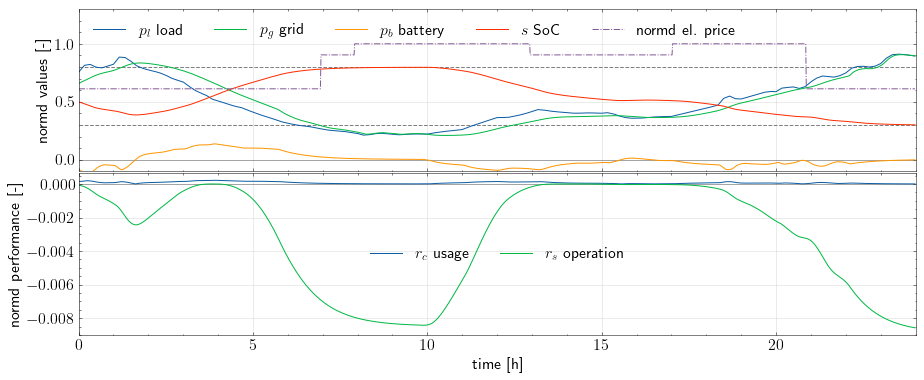

((-0.04408137152258717,
  3.9466535009310943,
  0.058332408987389776,
  0.10455997287103001),
 30.09534800196493,
 30.101272063269935)

In [70]:
RBCpar=opt_ucb.get_maximum(context=0.,beta_estimate=0)
plant_cost(RBCpar[0],p_load=data.power_load.values[0*day:], plot=True)

# Evaluation 

In [291]:
import glob
paths=glob.glob('sim_data_312_winter_rp_qf/y_post_loglike_b*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas


['2022_03_05_0602',
 '2022_03_05_0602',
 '2022_03_05_0242',
 '2022_03_05_0546',
 '2022_03_05_0602',
 '2022_03_05_0637',
 '2022_03_05_0637',
 '2022_03_05_0546',
 '2022_03_05_0546',
 '2022_03_05_0242',
 '2022_03_05_0637',
 '2022_03_05_0637',
 '2022_03_05_0602',
 '2022_03_05_0546']

In [296]:
ct=10
mae=[]
cnst10=[]
cnst0=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:,0]
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:]
    mae.append(np.abs(err).sum()/(len(cst)-ct))
    cnst=get_data(path)[:,1]
    cnst10.append((cnst<-0.1).astype(int).sum())
    cnst0.append((cnst<-0).astype(int).sum())    
    print(file_paths[i],(cnst<-0).astype(int).sum())

y_post_loglike_b2_SBO_2022_03_05_0602.npy 5
y_post_loglike_b2_BO_2022_03_05_0602.npy 36
y_post_loglike_b2_CSBO_2022_03_05_0242.npy 19
y_post_loglike_b1_CSBO_2022_03_05_0546.npy 5
y_post_loglike_b2_SBOb_2022_03_05_0602.npy 1
y_post_loglike_b05_SBOb_2022_03_05_0637.npy 2
y_post_loglike_b05_BO_2022_03_05_0637.npy 37
y_post_loglike_b1_BO_2022_03_05_0546.npy 36
y_post_loglike_b1_SBO_2022_03_05_0546.npy 6
y_post_loglike_b2_SBO_2022_03_05_0242.npy 5
y_post_loglike_b05_SBO_2022_03_05_0637.npy 13
y_post_loglike_b05_CSBO_2022_03_05_0637.npy 19
y_post_loglike_b2_CSBO_2022_03_05_0602.npy 0
y_post_loglike_b1_SBOb_2022_03_05_0546.npy 1


In [292]:
eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst0':cnst0,'cnst10':cnst10,'date':dates})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
eval_df.sort_values('mae')


mae  cnst0  cnst10             date
beta optype                                          
0.5  BO      0.986575     37      37  2022_03_05_0637
     CSBO    0.635154     19       2  2022_03_05_0637
     SBO     0.286739     13       0  2022_03_05_0637
     SBOb    2.986477      2       2  2022_03_05_0637
1.0  BO      1.370720     36      34  2022_03_05_0546
     CSBO    1.215400      5       0  2022_03_05_0546
     SBO     0.368464      6       0  2022_03_05_0546
     SBOb    3.231044      1       1  2022_03_05_0546
2.0  BO      1.147769     36      35  2022_03_05_0602
     CSBO    0.931918     19       4  2022_03_05_0242
     CSBO    1.795221      0       0  2022_03_05_0602
     SBO     0.618568      5       1  2022_03_05_0602
     SBO     0.618568      5       1  2022_03_05_0242
     SBOb    4.086556      1       1  2022_03_05_0602

3 3 1


 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


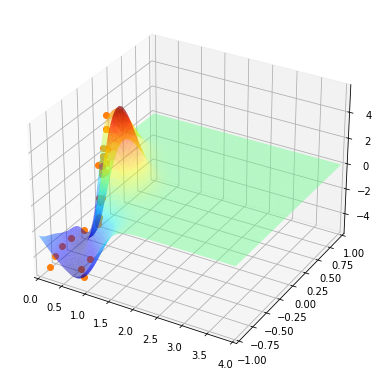

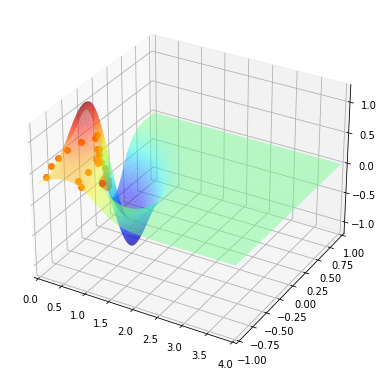

In [140]:
opt_ucb.context=[[0.3]]
opt_ucb.plot(100,plot_3d=True)

3 3 1


 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


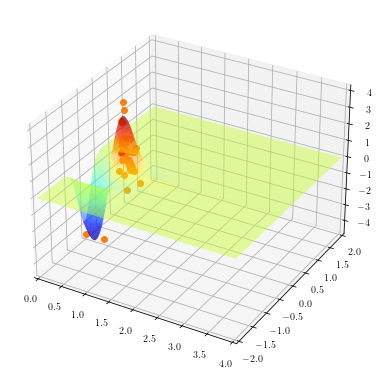

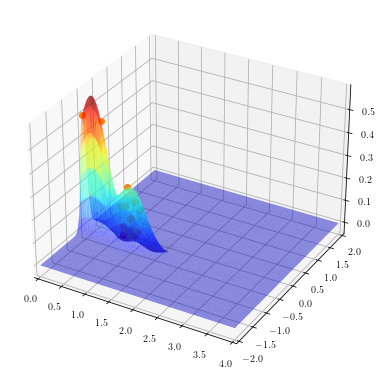

In [66]:
opt_ucb.context=[[0.1]]
opt_ucb.plot(100,plot_3d=True)

In [69]:
def gmax_const(opt,cnt=S_os_max):     
    x,y = opt.data
    max_idx=y[y[:,1]>=-cnt][:,0].argmax()
    return x[y[:,1]>=-cnt][max_idx], y[y[:,1]>=-cnt][:,0].max()
gmax_const(opt_ucb,0)

(array([ 0.83366733, -0.42084168,  0.08682725]), 4.150355788998919)